In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Import Data

In [2]:
df = pd.read_csv("data/carprice.csv", index_col="ID")
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
ID,,,,,,,,,,,,
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50


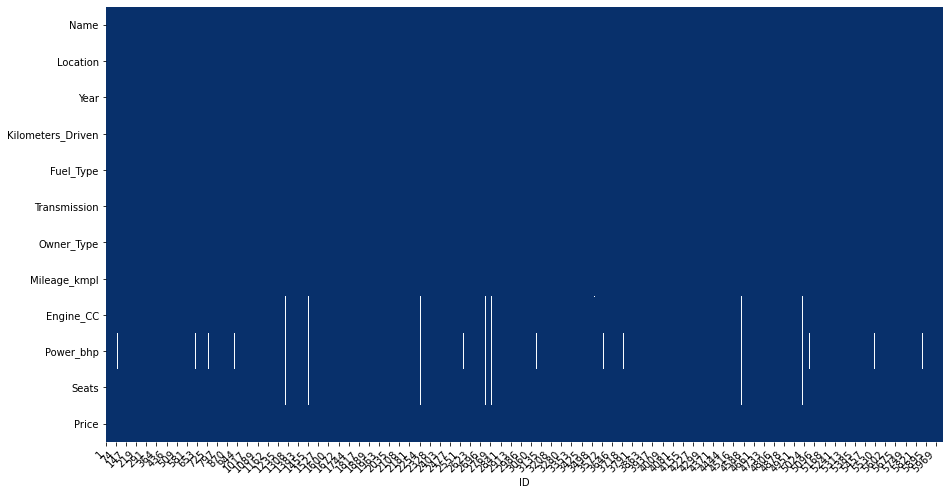

In [3]:
plot_missing_value(df)

In [4]:
df.drop(columns="Name", inplace=True)

# Dataset Splitting

In [5]:
# untuk regresion memakai shuffle split saja
X = df.drop(columns="Price")
y = df.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4762, 10), (1191, 10), (4762,), (1191,))

# Training

In [6]:
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp
from sklearn.svm import SVR

In [7]:
X_train.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats
ID,,,,,,,,,,
4380,Coimbatore,2016,60913,Petrol,Manual,First,20.73,1373.0,91.1,5.0
2676,Kochi,2017,40459,Diesel,Manual,First,19.67,1582.0,126.2,5.0
647,Jaipur,2004,200000,Petrol,Manual,First,0.00,1086.0,NaN,5.0
5966,Hyderabad,2018,1048,Petrol,Manual,First,18.90,998.0,67.1,5.0
2198,Ahmedabad,2013,96000,Diesel,Manual,Second,23.50,1498.0,90.0,5.0


In [8]:
X_train.columns #untuk menentukan mana data yang kategorik dan mana yang numerik supaya tidak typo

Index(['Location', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission',
       'Owner_Type', 'Mileage_kmpl', 'Engine_CC', 'Power_bhp', 'Seats'],
      dtype='object')

In [10]:
X_train.Seats.value_counts() #Melihat data kursi mobil apakah cocok ke numeric atau kategorik

5.0     3946
7.0      545
8.0      111
4.0       74
6.0       28
2.0       15
10.0       4
9.0        3
Name: Seats, dtype: int64

In [11]:
gsp.svm_params #rekomendasi untuk mengatur gamma dan penalty C , bisa dicoba coba angka lain, terlihat dibawah itu dari 10 pgkt -3 dst

{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [12]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["Year", "Kilometers_Driven", "Mileage_kmpl", "Engine_CC", "Power_bhp", "Seats"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location", "Fuel_Type", "Transmission", "Owner_Type"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1) #cv adalah cross validation kita ambil saja 3, supaya running gaterlalu lama juga
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_tra in), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:   27.5s finished
C:\Users\ACER\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 10.0, 'algo__gamma': 0.001}
0.4191924234077009 0.08719422320538917 0.055845667362476537


### dapat kita lihat hasil diatas sangat jauh dari kata baik karena kita belum terlalu baik dalam memakai SVM, SVM ini sangat bergantung pada DISTANCE, jadi svm ini biasanya kita kasih scalling
#ingat scalling itu pada data yg numeric ya

# Scalling can help SVM dan KNN

In [15]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ["Year", "Kilometers_Driven", "Mileage_kmpl", "Engine_CC", "Power_bhp", "Seats"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location", "Fuel_Type", "Transmission", "Owner_Type"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1) #cv adalah cross validation kita ambil saja 3, supaya running gaterlalu lama juga
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:   13.9s finished
C:\Users\ACER\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.8595035899603412 0.8331947362805839 0.8197066934420882


In [16]:
#terlihat lebih baik ya dari sebelumnya
#dibawah ini scalling pake robust

In [19]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ["Year", "Kilometers_Driven", "Mileage_kmpl", "Engine_CC", "Power_bhp", "Seats"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location", "Fuel_Type", "Transmission", "Owner_Type"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1) #cv adalah cross validation kita ambil saja 3, supaya running gaterlalu lama juga
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:   13.6s finished
C:\Users\ACER\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.8692907569381978 0.8365068850275925 0.8314246832596819


### Algoritma itu bukan tentang mana yang bagus, tapi kita harus tau dengan baik masing-masing cara pakainya bagaimana -Wira Dharma Kencana Putra

# Polynomial Features

In [17]:
from luwiji.svm import demo

In [18]:
demo.poly_features()

interactive(children=(ToggleButtons(description='degree', options=(1, 2, 3), value=1), Checkbox(value=False, d…

In [21]:
gsp.svm_poly_params

{'prep__numeric__poly__degree': [1, 2, 3],
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [22]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, scaling='robust'), ["Year", "Kilometers_Driven", "Mileage_kmpl", "Engine_CC", "Power_bhp", "Seats"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location", "Fuel_Type", "Transmission", "Owner_Type"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_poly_params, cv=3, n_jobs=-1, verbose=1) #cv adalah cross validation kita ambil saja 3, supaya running gaterlalu lama juga
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:  1.7min finished
C:\Users\ACER\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 10.0, 'algo__gamma': 0.1, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.8692907569381978 0.8365068850275925 0.8314246832596819


# Save Model

In [23]:
save_model(model.best_estimator_, "car_price.pkl")

Model is pickled as model/car_price.pkl
